In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 34 kB/s 
     |████████████████████████████████| 198 kB 42.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=0170e18c666a9f15a9fa62a4b6af877598f01ff9282b69e20b3fcf84b0b05c95
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession,SQLContext

from pyspark.sql.types import *
from pyspark.sql.functions import udf, col
import pyspark.sql.functions as F

from pyspark.ml.feature import VectorAssembler

from pyspark.ml.clustering import KMeans

from pyspark.sql.functions import *

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(18, 4))

import seaborn as sns
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})

np.set_printoptions(precision=4, suppress=True)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
rnd_seed=42
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [ ]:
spark = (SparkSession
         .builder
         .master("local[*]")
         .appName("cluster-uber-trip-data")
         .getOrCreate())
spark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
UBER_DATA=('/content/drive/MyDrive/uber/uber-raw-data-jun14.csv')

In [ ]:
schema = StructType([
    StructField("dt", TimestampType(), nullable=False),
    StructField("lat", DoubleType(), nullable=False),
    StructField("lon", DoubleType(), nullable=False),
    StructField("base", StringType(), nullable=True)]
  )

In [ ]:
uber_df = spark.read.csv(UBER_DATA, header=True,schema=schema)
uber_df.cache()

DataFrame[dt: timestamp, lat: double, lon: double, base: string]

In [ ]:
uber_df.show(10)

+-------------------+-------+--------+------+
|                 dt|    lat|     lon|  base|
+-------------------+-------+--------+------+
|2014-06-01 00:00:00|40.7293| -73.992|B02512|
|2014-06-01 00:01:00|40.7131|-74.0097|B02512|
|2014-06-01 00:04:00|40.3461| -74.661|B02512|
|2014-06-01 00:04:00|40.7555|-73.9833|B02512|
|2014-06-01 00:07:00| 40.688|-74.1831|B02512|
|2014-06-01 00:08:00|40.7152|-73.9917|B02512|
|2014-06-01 00:08:00|40.7282| -73.991|B02512|
|2014-06-01 00:08:00|40.3042|-73.9794|B02512|
|2014-06-01 00:09:00| 40.727|-73.9915|B02512|
|2014-06-01 00:10:00|40.7221|-73.9965|B02512|
+-------------------+-------+--------+------+
only showing top 10 rows



In [ ]:
uber_df.printSchema()

root
 |-- dt: timestamp (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- base: string (nullable = true)



In [ ]:
uber_df.count()

542830

In [ ]:
uber_df.describe(["dt", "lat", "lon"]).show()

+-------+-------------------+-------------------+
|summary|                lat|                lon|
+-------+-------------------+-------------------+
|  count|             542830|             542830|
|   mean| 40.739974051176084| -73.97416819888568|
| stddev|0.03832608279538559|0.05618794458572163|
|    min|            39.9558|           -74.8594|
|    max|            41.3199|           -72.6966|
+-------+-------------------+-------------------+



In [ ]:
feature_columns = ['lat', 'lon']

In [ ]:
feature_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [ ]:
uber_assembled_df = feature_assembler.transform(uber_df)
uber_assembled_df.cache()

DataFrame[dt: timestamp, lat: double, lon: double, base: string, features: vector]

In [ ]:
uber_assembled_df.show(10)

+-------------------+-------+--------+------+------------------+
|                 dt|    lat|     lon|  base|          features|
+-------------------+-------+--------+------+------------------+
|2014-06-01 00:00:00|40.7293| -73.992|B02512| [40.7293,-73.992]|
|2014-06-01 00:01:00|40.7131|-74.0097|B02512|[40.7131,-74.0097]|
|2014-06-01 00:04:00|40.3461| -74.661|B02512| [40.3461,-74.661]|
|2014-06-01 00:04:00|40.7555|-73.9833|B02512|[40.7555,-73.9833]|
|2014-06-01 00:07:00| 40.688|-74.1831|B02512| [40.688,-74.1831]|
|2014-06-01 00:08:00|40.7152|-73.9917|B02512|[40.7152,-73.9917]|
|2014-06-01 00:08:00|40.7282| -73.991|B02512| [40.7282,-73.991]|
|2014-06-01 00:08:00|40.3042|-73.9794|B02512|[40.3042,-73.9794]|
|2014-06-01 00:09:00| 40.727|-73.9915|B02512| [40.727,-73.9915]|
|2014-06-01 00:10:00|40.7221|-73.9965|B02512|[40.7221,-73.9965]|
+-------------------+-------+--------+------+------------------+
only showing top 10 rows



In [ ]:
train_df, test_df = uber_assembled_df.randomSplit([0.7, 0.3], seed=rnd_seed)

In [ ]:
train_df.cache()
test_df.cache()

DataFrame[dt: timestamp, lat: double, lon: double, base: string, features: vector]

DataFrame[dt: timestamp, lat: double, lon: double, base: string, features: vector]

In [ ]:
uber_df.unpersist()
uber_assembled_df.unpersist()

DataFrame[dt: timestamp, lat: double, lon: double, base: string]

DataFrame[dt: timestamp, lat: double, lon: double, base: string, features: vector]

In [ ]:
kmeans = KMeans(k=8, initMode='k-means||', featuresCol='features', predictionCol='cluster', maxIter=10)

In [ ]:
kmModel = kmeans.fit(train_df)

In [ ]:
print("KMeans Cluster Centers: ")
a=[]
for center in kmModel.clusterCenters():
    print(center)

KMeans Cluster Centers: 
[ 40.7314 -73.9984]
[ 40.7657 -73.8733]
[ 40.6875 -73.9665]
[ 40.6554 -73.7809]
[ 40.8908 -73.8852]
[ 40.6972 -74.2027]
[ 40.7609 -73.5326]
[ 40.7653 -73.973 ]


In [ ]:
test_preds=kmModel.transform(test_df)

In [ ]:
test_preds.show()

+----+-------+--------+------+------------------+-------+
|  dt|    lat|     lon|  base|          features|cluster|
+----+-------+--------+------+------------------+-------+
|null|40.0937|-74.0373|B02512|[40.0937,-74.0373]|      2|
|null|40.1097| -74.035|B02512| [40.1097,-74.035]|      2|
|null|40.1105|-74.0342|B02598|[40.1105,-74.0342]|      2|
|null|40.1111|-74.0342|B02512|[40.1111,-74.0342]|      2|
|null|40.1222|-74.0492|B02512|[40.1222,-74.0492]|      2|
|null|40.1301|-74.0431|B02512|[40.1301,-74.0431]|      2|
|null|40.1362|-74.0328|B02598|[40.1362,-74.0328]|      2|
|null|40.1461|-74.0483|B02512|[40.1461,-74.0483]|      2|
|null|40.1585|-74.0251|B02512|[40.1585,-74.0251]|      2|
|null|40.1636|-74.0487|B02598|[40.1636,-74.0487]|      2|
|null|40.1725|-74.0276|B02512|[40.1725,-74.0276]|      2|
|null| 40.175|-74.0273|B02598| [40.175,-74.0273]|      2|
|null| 40.175|-74.0184|B02512| [40.175,-74.0184]|      2|
|null|40.1755|-74.0174|B02512|[40.1755,-74.0174]|      2|
|null|40.1776|

In [ ]:
print(kmModel.summary.clusterSizes) # No of points in each cluster

[101551, 11710, 76557, 38032, 4243, 13298, 106889, 27624]


In [ ]:
print(kmModel.summary.trainingCost)

350.02038961709695


In [ ]:
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')
plt.title('Clusters of Customers')
plt.xlabel('Annual Income(k$)')
plt.ylabel('Spending Score(1-100')
plt.show()

In [ ]:
kmModel.write().overwrite().save("data/model")

In [ ]:
#Which hours of the day and which cluster had the highest number of pickups?    

In [ ]:
test_preds.createOrReplaceTempView("test_preds")

In [ ]:
plt.figure(figsize=(18,4))
sns.scatterplot(x='lat', y="lon", hue="cluster", data=test_df.toPandas());

ValueError: ignored

<Figure size 1296x288 with 0 Axes>

In [ ]:
import re

def strip_margin(text):
    nomargin = re.sub('\n[ \t]*\|', ' ', text)
    trimmed = re.sub('\s+', ' ', nomargin)
    return trimmed

In [ ]:
sql_result_df = spark.sql(strip_margin(
                        """SELECT 
                          |    HOUR(dt) AS hour, 
                          |    cluster,
                          |    COUNT(*) as count
                          |FROM test_preds
                          |GROUP BY hour, cluster
                          |ORDER BY count DESC
                        """))
sql_result_df.cache()

DataFrame[hour: int, cluster: int, count: bigint]

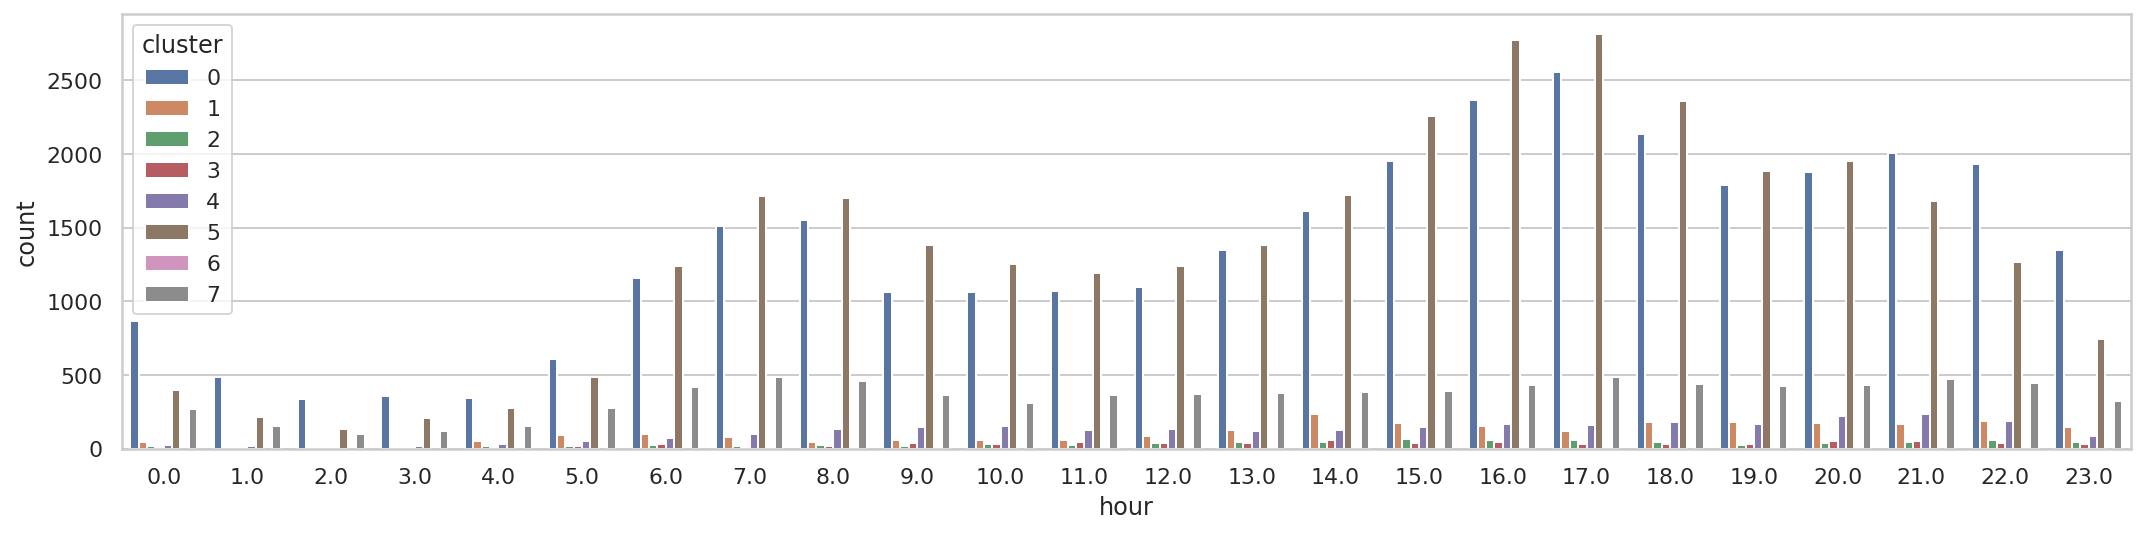

In [ ]:
plt.figure(figsize=(18,4))
sns.barplot(x="hour", y="count", hue="cluster", data=sql_result_df.toPandas());

In [ ]:
sql_result_df.unpersist()

DataFrame[hour: int, cluster: int, count: bigint]

In [ ]:
(test_preds
    .select(F.hour("dt").alias("hour"), "cluster")
    .groupBy(["hour", "cluster"])
    .count()
    .orderBy(F.desc("count"))).show(10)

+----+-------+-----+
|hour|cluster|count|
+----+-------+-----+
|null|      0|34020|
|null|      5|31266|
|null|      7|10022|
|null|      4| 3135|
|  17|      5| 2812|
|  16|      5| 2775|
|  17|      0| 2556|
|null|      1| 2524|
|  16|      0| 2364|
|  18|      5| 2357|
+----+-------+-----+
only showing top 10 rows



In [ ]:
#How many pickups occurred in each cluster?

In [ ]:
sql_result_df = spark.sql(strip_margin(
                        """SELECT cluster, COUNT(cluster) AS count
                          |FROM test_preds
                          |GROUP BY cluster
                          |ORDER BY cluster
                        """))
sql_result_df.cache()

DataFrame[cluster: int, count: bigint]

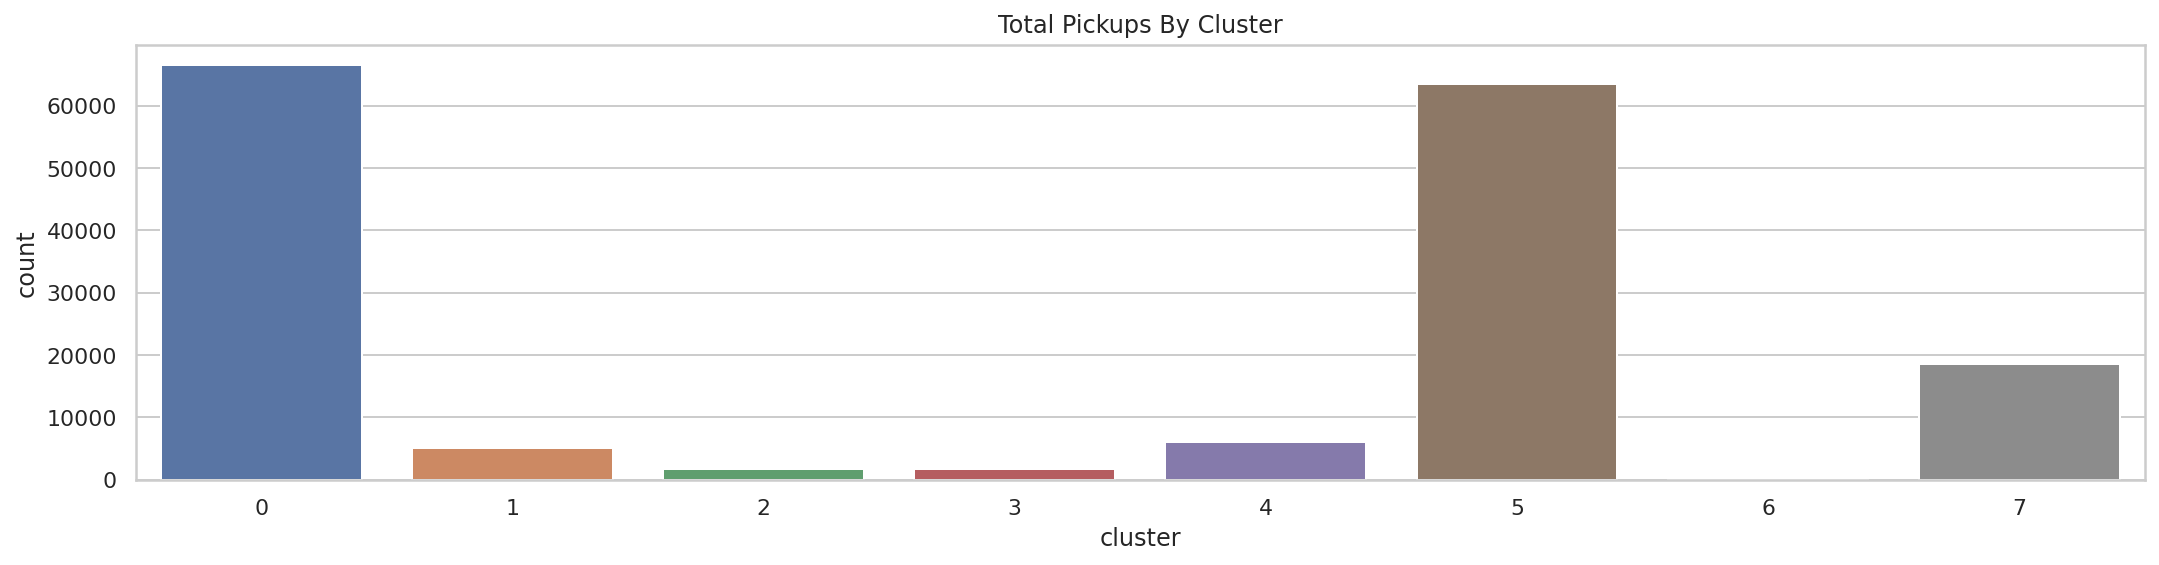

In [ ]:
plt.figure(figsize=(18,4))
sns.barplot(x="cluster", y="count", data=sql_result_df.toPandas())
plt.title("Total Pickups By Cluster");

In [ ]:
#How many pickups occurred in each hour?

In [ ]:
sql_result_df = spark.sql(strip_margin(
                        """SELECT 
                          |    HOUR(dt) AS hour, 
                          |    COUNT(cluster) AS count
                          |FROM test_preds
                          |GROUP BY hour
                          |ORDER BY hour
                        """))
sql_result_df.cache()

DataFrame[hour: int, count: bigint]

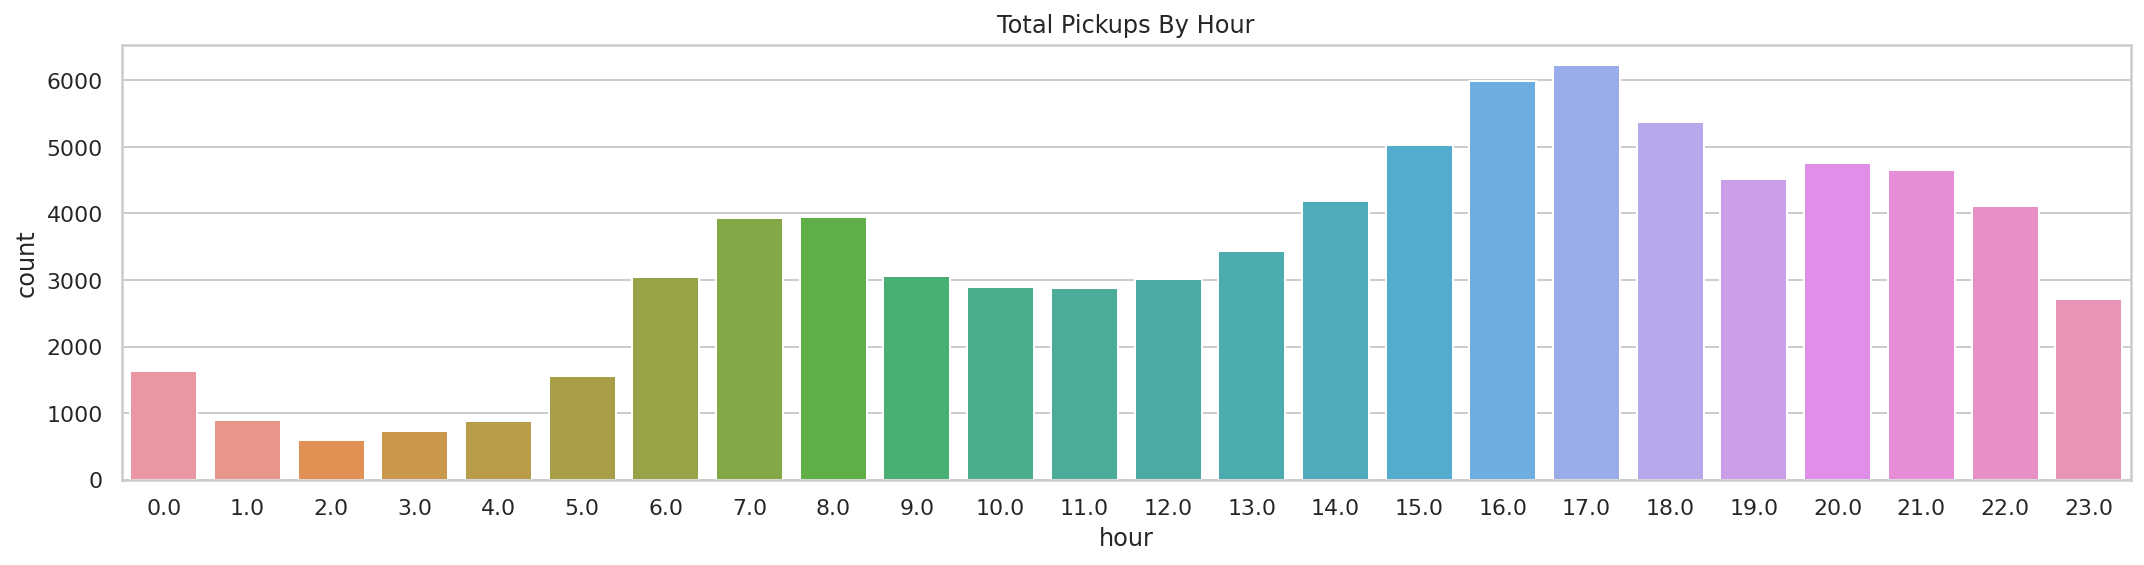

In [ ]:
plt.figure(figsize=(18,4))
sns.barplot(x="hour", y="count", data=sql_result_df.toPandas())
plt.title("Total Pickups By Hour");